✅ Preprocessing done → matches_processed.csv saved

Class Balance:
target_win_team1
0    0.503208
1    0.496792
Name: proportion, dtype: float64


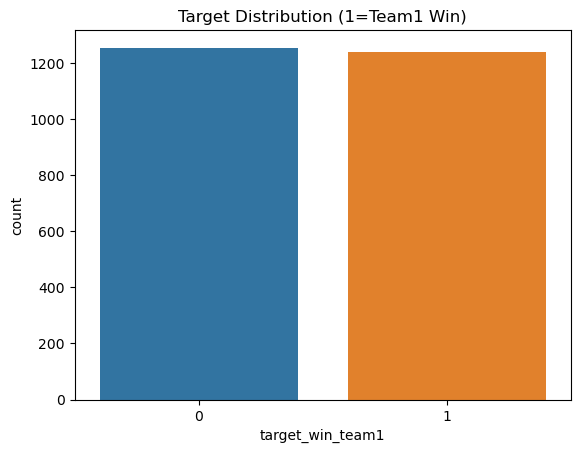

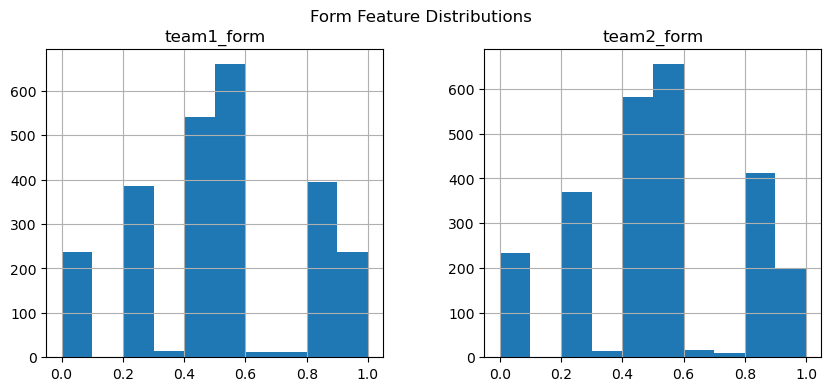


Top 10 Venues:
 venue
United Arab Emirates    242
South Africa            143
Oman                    129
Rwanda                  129
India                   125
West Indies             117
Bangladesh              110
Australia                99
England                  86
New Zealand              85
Name: count, dtype: int64

--- Logistic Regression ---
Accuracy: 0.5531062124248497
ROC-AUC: 0.6009751317311399


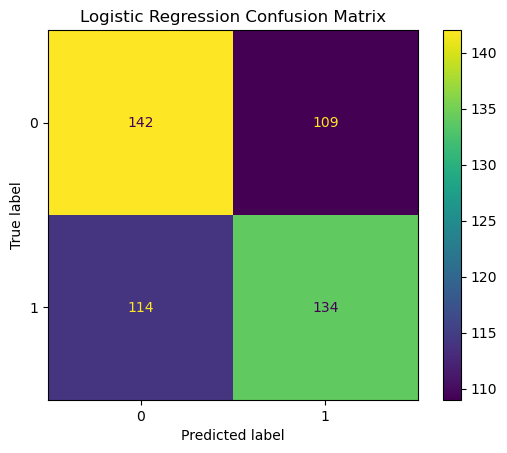


--- Random Forest ---
Accuracy: 0.5150300601202404
ROC-AUC: 0.5425314869554042


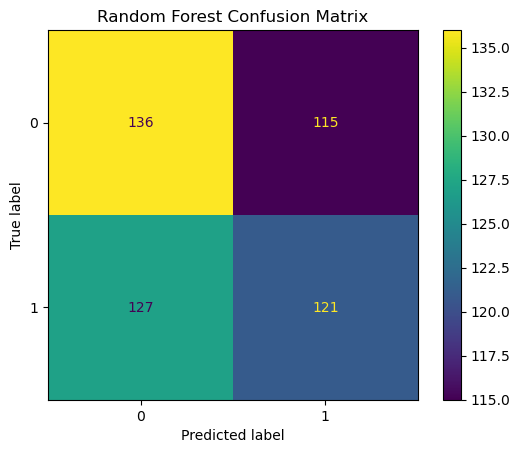

In [2]:
# ===============================================
# 1. Libraries
# ===============================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# ===============================================
# 2. Load Raw Matches Data
# ===============================================
matches = pd.read_csv("C:/Users/praty/Downloads/archive (1)/t20i_Matches_Data.csv")

# Keep only useful columns
df = matches[['Match Date', 'Team1 Name', 'Team2 Name',
              'Match Venue (Country)', 'Match Winner',
              'Toss Winner', 'Toss Winner Choice']].copy()

# Standardize column names
df = df.rename(columns={
    'Match Date': 'date',
    'Team1 Name': 'team1',
    'Team2 Name': 'team2',
    'Match Venue (Country)': 'venue',
    'Match Winner': 'winner',
    'Toss Winner': 'toss_winner',
    'Toss Winner Choice': 'toss_choice'
})

# Parse dates
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# ===============================================
# 3. Clean Matches
# ===============================================
# Drop ties / no results
df = df[df['winner'].notna()]
df = df[(df['winner'] == df['team1']) | (df['winner'] == df['team2'])]

# Target variable
df['target_win_team1'] = (df['winner'] == df['team1']).astype(int)

# Sort chronologically
df = df.sort_values('date').reset_index(drop=True)

# ===============================================
# 4. Rolling Form Feature (last 5 games)
# ===============================================
history = {}
team1_forms, team2_forms = [], []

for _, row in df.iterrows():
    t1, t2, winner = row['team1'], row['team2'], row['winner']

    # Get last history (default 0.5 if no games yet)
    t1_hist = history.get(t1, [])
    t2_hist = history.get(t2, [])

    team1_forms.append(sum(t1_hist)/len(t1_hist) if t1_hist else 0.5)
    team2_forms.append(sum(t2_hist)/len(t2_hist) if t2_hist else 0.5)

    # Update history
    history.setdefault(t1, []).append(1 if winner == t1 else 0)
    history.setdefault(t2, []).append(1 if winner == t2 else 0)

    # Keep last 5 only
    history[t1] = history[t1][-5:]
    history[t2] = history[t2][-5:]

df['team1_form'] = team1_forms
df['team2_form'] = team2_forms

# ===============================================
# 5. Toss Features
# ===============================================
df['toss_team1'] = (df['toss_winner'] == df['team1']).astype(int)
df['toss_team2'] = (df['toss_winner'] == df['team2']).astype(int)
df['toss_bat']   = (df['toss_choice'] == "bat").astype(int)
df['toss_bowl']  = (df['toss_choice'] == "bowl").astype(int)

# ===============================================
# 6. Final Dataset
# ===============================================
processed = df[['date','team1','team2','venue',
                'team1_form','team2_form',
                'toss_team1','toss_team2','toss_bat','toss_bowl',
                'target_win_team1']]

processed.to_csv("matches_processed.csv", index=False)
print("Preprocessing done → matches_processed.csv saved")

# ===============================================
# 7. EDA
# ===============================================
print("\nClass Balance:")
print(processed['target_win_team1'].value_counts(normalize=True))

sns.countplot(x='target_win_team1', data=processed)
plt.title("Target Distribution (1=Team1 Win)")
plt.show()

processed[['team1_form','team2_form']].hist(bins=10, figsize=(10,4))
plt.suptitle("Form Feature Distributions")
plt.show()

print("\nTop 10 Venues:\n", processed['venue'].value_counts().head(10))

# ===============================================
# 8. ML Preparation
# ===============================================
X = processed[['team1_form','team2_form','venue',
               'toss_team1','toss_team2','toss_bat','toss_bowl']]
y = processed['target_win_team1']

# Encode categorical venue
preprocessor = ColumnTransformer(
    transformers=[('venue', OneHotEncoder(handle_unknown='ignore'), ['venue'])],
    remainder='passthrough'
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================================
# 9. Baseline Logistic Regression
# ===============================================
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
logreg.fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)[:,1]

print("\n--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_log)).plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# ===============================================
# 10. Baseline Random Forest
# ===============================================
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()
